In [1]:
import quandl
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import json
import datetime as dt
from datetime import datetime
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.weightstats import ttest_ind
from scipy import stats

## Data Gathering: Quandl API

In [2]:
# Federal Debt: Total Public Debt as Percent of Gross Domestic Product, Quarterly
# Units: Percent of GDP, Seasonally Adjusted
# Source: FRED (Federal Reserve Bank St. Louis)

debt = quandl.get("FRED/GFDEGDQ188S", authtoken="ckJvd5G2a2dkK9nun3xS")

In [3]:
# S&P 500 Index Composite, Monthly
# Units: Index
# Source: Yale University, Online Data Robert Shiller

sp = quandl.get("YALE/SPCOMP", authtoken="ckJvd5G2a2dkK9nun3xS")

In [4]:
# Unemployment Rate, Monthly
# Units: Percent, Seasonally Adjusted
# Source: FRED (Federal Reserve Bank St. Louis)

u = quandl.get("FRED/UNRATENSA", authtoken="ckJvd5G2a2dkK9nun3xS")

In [5]:
# Balance on Current Account, NIPA's, Quarterly
# Units: Billions of Dollars Seasonally Adjusted Annual Rate
# Source: FRED (Federal Reserve Bank St. Louis)

balance = quandl.get("FRED/BOPGSTB", authtoken="ckJvd5G2a2dkK9nun3xS")

In [6]:
# US Presidents 
presidents = pd.read_csv('us_presidents.csv')
presidents = pd.DataFrame(presidents)

## Data Cleaning: 

### S&P 500 Index: Monthly Returns

In [7]:
# Get the date in a new column to be able to merge tables on Date
sp['Date'] = sp.index

# Adding a new column with t-1 (lag) values to calculate monthly returns on S&P
sp['lag'] = sp['S&P Composite'].shift(1)
                                      
# As there is no lagged S&P for the first date we delete the first row
to_drop = sp.iloc[:1]

sp.drop(to_drop.index, axis=0, inplace=True)
                                      
# The S&P monthly returns is simply the rate of change between months ((t - t-1)/t-1)*100
sp['monthly_return_per'] = ((sp['S&P Composite']-sp['lag'])/sp['lag'])*100

### US Goverment Debt: 1st Difference

Taking 1st difference (t - t-1)

In [8]:
debt['Date'] = debt.index
debt['lag'] = debt.Value.shift(1)
to_drop = debt.iloc[:1]
debt.drop(to_drop.index, axis=0, inplace=True)

In [9]:
debt['diff'] = debt['Value'] - debt['lag']

debt.head()

,Value,Date,lag,diff
Date,,,,
1966-04-01,39.26763,1966-04-01,40.33999,-1.07236
1966-07-01,39.62091,1966-07-01,39.26763,0.35328
1966-10-01,39.51977,1966-10-01,39.62091,-0.10114
1967-01-01,39.20383,1967-01-01,39.51977,-0.31594
1967-04-01,38.03292,1967-04-01,39.20383,-1.17091


### US Unemployment Rate: 1st Difference

Taking 1st difference (t - t-1)

In [10]:
u['Date'] = u.index
u['lag'] = u.Value.shift(1)
to_drop = u.iloc[:1]
u.drop(to_drop.index, axis=0, inplace=True)

In [11]:
u['diff'] = u['Value'] - u['lag']

u.head()

,Value,Date,lag,diff
Date,,,,
1948-02-01,4.7,1948-02-01,4.0,0.7
1948-03-01,4.5,1948-03-01,4.7,-0.2
1948-04-01,4.0,1948-04-01,4.5,-0.5
1948-05-01,3.4,1948-05-01,4.0,-0.6
1948-06-01,3.9,1948-06-01,3.4,0.5


### Trade Balance: 1st Difference

In [12]:
balance['Date'] = balance.index
balance['lag'] = balance['Value'].shift(1)
to_drop = balance.iloc[:1]
balance.drop(to_drop.index, axis=0, inplace=True)

In [13]:
balance['diff'] = ((balance['Value']-balance['lag']))

## Data Merging

### Merging Presidents data to S&P data

In [14]:
date_end_series = list(presidents['end'])

In [15]:
#Adding missing end date for Obama and using today's data for Trump as he is still in Office

date_end_series[-2] = 'January 20, 2017'
date_end_series[-1] = 'November 12, 2019'

In [16]:
# Converting presidents final dates in office into a datetime object

new_date_end_series = []
for row in date_end_series:
    date = dt.datetime.strptime(row,'%B %d, %Y').strftime('%Y-%m-%d')
    datetime_object = datetime.strptime(date, '%Y-%m-%d')
    new_date_end_series.append(datetime_object)

In [17]:
# presidents['end_date'] = new_date_end_series

presidents['end_date'] = new_date_end_series
new_president_df = presidents[['president', 'end_date']].copy()


In [18]:
# Deleting presidents before S&P Index start date

to_drop  = new_president_df[:17].index
new_president_df = new_president_df.drop(to_drop, axis = 0)

In [19]:
# Indexing each dataframe by year/month

presidents['month'] = presidents['end_date'].dt.month
presidents['year'] = presidents['end_date'].dt.year
presidents['monthyear'] = presidents['year'].map(str) + '/' + presidents['month'].map(str)

sp['month'] = sp['Date'].dt.month
sp['year'] = sp['Date'].dt.year
sp['monthyear'] = sp['year'].map(str) + '/' + sp['month'].map(str)

In [20]:
# new dataframe, merged from old dataframes on date

df = sp.merge( presidents, on='monthyear', how='left')

# Selecting only columns we want

sp_p = df[['Date','S&P Composite','monthly_return_per', 'president']]

# filling in all presidents 

sp_p['president'] = sp_p['president'].fillna(method='backfill')

# filling in Donald trump (as there was no endate)

sp_p.president.fillna('Donald Trump', inplace = True)

C:\Users\aroag\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\aroag\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [21]:
sp_p.to_csv('clean_sp.csv')

In [22]:
sp_p.tail()

,Date,S&P Composite,monthly_return_per,president
1778,2019-04-30,2903.80,3.559940,Donald Trump
1779,2019-05-31,2854.71,-1.690543,Donald Trump
1780,2019-06-30,2890.17,1.242158,Donald Trump
1781,2019-07-31,2996.11,3.665528,Donald Trump
1782,2019-08-31,2883.98,-3.742519,Donald Trump


### Merging Unemployment and Presidents

In [23]:
u['Date'] = u.index

In [24]:
u['month'] = u['Date'].dt.month
u['year'] = u['Date'].dt.year
u['monthyear'] = u['year'].map(str) + '/' + u['month'].map(str)

In [25]:
df_u = u.merge(presidents, on='monthyear', how='left')
u_p = df_u[['Date','Value','diff', 'president']]
u_p['president'] = u_p['president'].fillna(method='backfill')
u_p.president.fillna('Donald Trump', inplace = True)

C:\Users\aroag\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
u_p.tail()

,Date,Value,diff,president
855,2019-05-01,3.4,0.1,Donald Trump
856,2019-06-01,3.8,0.4,Donald Trump
857,2019-07-01,4.0,0.2,Donald Trump
858,2019-08-01,3.8,-0.2,Donald Trump
859,2019-09-01,3.3,-0.5,Donald Trump


### Merging Trade Balance & President

In [27]:
balance['Date'] = balance.index

In [28]:
balance['month'] = balance['Date'].dt.month
balance['year'] = balance['Date'].dt.year
balance['monthyear'] = balance['year'].map(str) + '/' + balance['month'].map(str)

In [29]:
df_b = balance.merge(presidents, on='monthyear', how='left')
b_p = df_b[['Date','Value','diff', 'president']]
b_p['president'] = b_p['president'].fillna(method='backfill')
b_p.president.fillna('Donald Trump', inplace = True)

C:\Users\aroag\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
b_p.head()

,Date,Value,diff,president
0,1992-02-01,-831.0,1195.0,George H. W. Bush
1,1992-03-01,-2641.0,-1810.0,George H. W. Bush
2,1992-04-01,-3109.0,-468.0,George H. W. Bush
3,1992-05-01,-3919.0,-810.0,George H. W. Bush
4,1992-06-01,-2824.0,1095.0,George H. W. Bush


### Merging Debt & President

In [31]:
debt['Date'] = debt.index

In [32]:
debt['month'] = debt['Date'].dt.month
debt['year'] = debt['Date'].dt.year
debt['monthyear'] = debt['year'].map(str) + '/' + debt['month'].map(str)

In [33]:
df_d = debt.merge(presidents, on='monthyear', how='left')
d_p = df_d[['Date','Value','diff', 'president']]
d_p['president'] = d_p['president'].fillna(method='backfill')
d_p.president.fillna('Donald Trump', inplace = True)

C:\Users\aroag\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
d_p.head()

,Date,Value,diff,president
0,1966-04-01,39.26763,-1.07236,Lyndon B. Johnson
1,1966-07-01,39.62091,0.35328,Lyndon B. Johnson
2,1966-10-01,39.51977,-0.10114,Lyndon B. Johnson
3,1967-01-01,39.20383,-0.31594,Lyndon B. Johnson
4,1967-04-01,38.03292,-1.17091,Lyndon B. Johnson


## Data Visualization

### Time Series

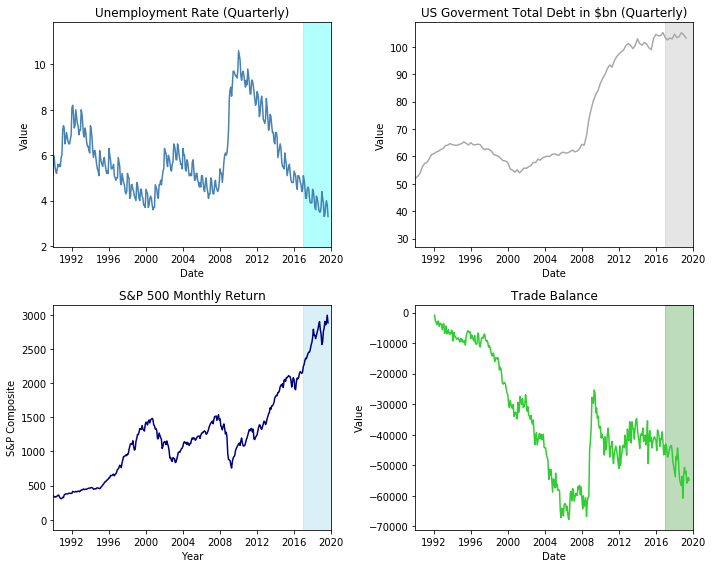

In [40]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))


sns.lineplot(x= u.index, y=u.Value, ax=axes[0][0], color='steelblue').set_title('Unemployment Rate (Quarterly)')
axes[0][0].axvspan('2017', '2020', alpha=0.3, color='cyan')
axes[0][0].set_xlim(['1990', '2020'])


sns.lineplot(x=debt.index, y=debt.Value, ax=axes[0][1], color='darkgray').set_title('US Goverment Total Debt in $bn (Quarterly)')
axes[0][1].axvspan('2017', '2020', alpha=0.2, color='grey')
axes[0][1].set_xlim(['1990', '2020'])

sns.lineplot(x= sp.index, y=sp['S&P Composite'], ax=axes[1][0], color='navy').set_title('S&P 500 Monthly Return')
axes[1][0].axvspan('2017', '2020', alpha=0.3, color='skyblue')
axes[1][0].set_xlim(['1990', '2020'])

sns.lineplot(x=balance.index, y=balance['Value'], ax=axes[1][1], color='limegreen').set_title('Trade Balance')
axes[1][1].axvspan('2017', '2020', alpha=0.3, color='forestgreen')
axes[1][1].set_xlim(['1990', '2020'])

fig.tight_layout()
plt.show()


### Distribution

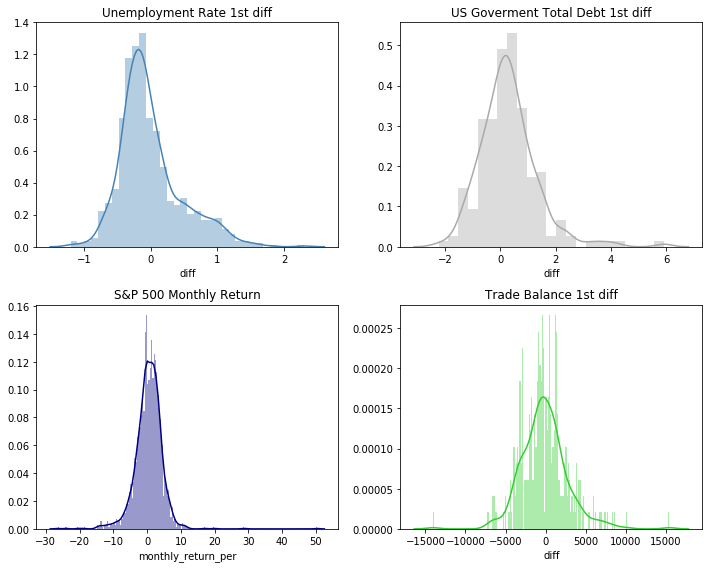

In [36]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))

sns.distplot(u['diff'], ax=axes[0][0], color='steelblue').set_title('Unemployment Rate 1st diff')
sns.distplot(debt['diff'], ax=axes[0][1], color= 'darkgray').set_title('US Goverment Total Debt 1st diff')
sns.distplot(sp['monthly_return_per'], ax=axes[1][0], bins=200, color='navy').set_title('S&P 500 Monthly Return')
sns.distplot(balance['diff'], ax=axes[1][1], bins=200, color='limegreen', hist=True).set_title('Trade Balance 1st diff')

fig.tight_layout()
plt.show()

In [37]:
sp_p['new_index'] = sp_p.groupby('president').cumcount()
pv = sp_p.reset_index().pivot(columns='president', values='S&P Composite', index='new_index')

C:\Users\aroag\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
pv_100.count()

NameError: name 'pv_100' is not defined

In [ ]:
pv_100 = pv.apply(lambda x: (x/x[0]*100))
pv_100.iloc[0] = 100

In [ ]:
plt.figure(figsize=(20,10))

for column in pv_100.drop('Donald Trump', axis=1):
       plt.plot(pv_100.index, pv_100[column], marker='',color='gray', linewidth=2, alpha=0.4)
plt.plot(pv_100.index, pv_100['Donald Trump'], marker='', color='red', linewidth=4, alpha=0.7)

plt.legend(loc='lower center',
          ncol=10, fancybox=True, shadow=True)
plt.title('S&P 500 Trend under each US president vs Trump')

## Hypothesis Testing: T-Test

### Hypothesis 1: S&P 500 Index

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">The S&amp;P just hit an ALL TIME HIGH. This is a big win for jobs, 401-K’s, and, frankly, EVERYONE! Our Country is doing great. Even killed long sought ISIS murderer, Al-Baghdadi. We are stronger than ever before, with GREAT upward potential. Enjoy!</p>&mdash; Donald J. Trump (@realDonaldTrump) <a href="https://twitter.com/realDonaldTrump/status/1188813055108374533?ref_src=twsrc%5Etfw">October 28, 2019</a></blockquote>


 
    h0 = Trump has no effect on the rate of growth of the s&p 500
    h1 = Trump is increasing the rate of growth of the s&p 500
    


In [ ]:
sp_p['trump'] = sp_p['president'].apply(lambda x: 1 if x=='Donald Trump' else 0)

trump_sp = sp_p.loc[(sp_p['president'] == 'Donald Trump')]
other_sp = sp_p.loc[(sp_p['president'] != 'Donald Trump')]


print(round(trump_sp['monthly_return_per'].mean(),2))
print(round(trump_sp['monthly_return_per'].var(),2))
print(round(other_sp['monthly_return_per'].mean(),2))
print(round(other_sp['monthly_return_per'].var()),2)


In [ ]:
sp_p.boxplot(column=['monthly_return_per'], by='trump')

In [ ]:
# Welch’s t-test (Scipy), which does not assume equal population variance

stats.ttest_ind(trump_sp['monthly_return_per'],other_sp['monthly_return_per'], equal_var = False)

### Hypothesis_2: Unemployment

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">Breaking News: Unemployment Rate, at 3.5%, drops to a 50 YEAR LOW. Wow America, lets impeach your President (even though he did nothing wrong!).</p>&mdash; Donald J. Trump (@realDonaldTrump) <a href="https://twitter.com/realDonaldTrump/status/1180102056411095042?ref_src=twsrc%5Etfw">October 4, 2019</a></blockquote>



    h0 = Trump has no effect on the rate of unemployment in the usa
    h1 = Trump has reduced the rate of unemployment in the USA



In [ ]:
u_p['trump'] = u_p['president'].apply(lambda x: 1 if x=='Donald Trump' else 0)

trump_u = u_p.loc[(u_p['president'] == 'Donald Trump')]
other_u = u_p.loc[(u_p['president'] != 'Donald Trump')]


print(round(trump_u['diff'].mean(),2))
print(round(trump_u['diff'].var(),2))
print(round(other_u['diff'].mean(),2))
print(round(other_u['diff'].var()),2)

In [ ]:
u_p.boxplot(column=['diff'], by='trump')

In [ ]:
# Welch’s t-test (Scipy), which does not assume equal population variance

stats.ttest_ind(trump_u['diff'],other_u['diff'], equal_var = False)

In [ ]:
# T-Test (statsmodesl)

ttest_ind(trump_s['diff'], other_s['diff'], alternative = 'two-sided', value=0)

As p-value is greater than 0.05 we cannot reject the null hypothesis of identical average between Trump's and all other US Presidents

### Hypothesis_3: US Gov Debt level

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">The media has not reported that the National Debt in my first month went down by $12 billion vs a $200 billion increase in Obama first mo.</p>&mdash; Donald J. Trump (@realDonaldTrump) <a href="https://twitter.com/realDonaldTrump/status/835479283699224576?ref_src=twsrc%5Etfw">February 25, 2017</a></blockquote>



    h0 = Trump has no effect on the level of debt in the USA
    h1 = Trump had reduced the level of national debt in the USA
    
   



In [ ]:
d_p['trump'] = d_p['president'].apply(lambda x: 1 if x=='Donald Trump' else 0)

trump_d = d_p.loc[(d_p['president'] == 'Donald Trump')]
other_d = d_p.loc[(d_p['president'] != 'Donald Trump')]


print(round(trump_d['diff'].mean(),2))
print(round(trump_d['diff'].var(),2))
print(round(other_d['diff'].mean(),2))
print(round(other_d['diff'].var()),2)

In [ ]:
d_p.boxplot(column=['diff'], by='trump')

In [ ]:
# Welch’s t-test (Scipy), which does not assume equal population variance

stats.ttest_ind(trump_s['diff'],other_s['diff'], equal_var = False)

### Hypothesis_4: Trade Balance

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">The trade deficit rose to a 7yr high thanks to horrible trade policies Clinton supports. I will fix it fast- JOBS! <a href="https://t.co/jaGeN4u50U">https://t.co/jaGeN4u50U</a></p>&mdash; Donald J. Trump (@realDonaldTrump) <a href="https://twitter.com/realDonaldTrump/status/743486962670141440?ref_src=twsrc%5Etfw">June 16, 2016</a></blockquote>


    h0 = Trump has no effect on the trade balance of the USA
    h1 = Trump is reducing the trade balance of the USA


In [ ]:
b_p['trump'] = b_p['president'].apply(lambda x: 1 if x=='Donald Trump' else 0)

trump_b = b_p.loc[(b_p['president'] == 'Donald Trump')]
other_b = b_p.loc[(b_p['president'] != 'Donald Trump')]

print(round(trump_b['diff'].mean(),2))
print(round(trump_b['diff'].var(),2))
print(round(other_s['diff'].mean(),2))
print(round(other_s['diff'].var()),2)

In [ ]:
b_p.boxplot(column=['diff'], by='trump')

In [ ]:
# Welch’s t-test (Scipy), which does not assume equal population variance

stats.ttest_ind(trump_b['diff'],other_b['diff'], equal_var = False)